In [1]:
# !pip install nltk

In [2]:
# # Uninstall current versions of the packages
# !pip uninstall -y numpy torch torchvision torchaudio albumentations transformers pillow tqdm wget jsonschema matplotlib

# # Install the latest stable versions of the packages
# !pip install numpy torch torchvision torchaudio albumentations transformers pillow tqdm wget jsonschema matplotlib

# # Verify installations
# !pip list


In [1]:
import os
import json
import shutil
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.amp import autocast
import random
import traceback
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transformers import AutoTokenizer, CLIPProcessor, CLIPConfig, CLIPModel, CLIPTokenizer
import gc


# Base Directory
BASE_PATH = r'C:\Users\csury\Documents\DL\PROJECT'

c:\Users\csury\anaconda3\envs\RL\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## DATA DOWNLOADING AND VERIFICATION

In [ ]:
# Creating project directories
directories = {
   'base': BASE_PATH,
   'data': os.path.join(BASE_PATH, 'DATA'),
   'models': os.path.join(BASE_PATH, 'models'), 
   'logs': os.path.join(BASE_PATH, 'logs'),
   'cache': os.path.join(BASE_PATH, 'DATA', 'cache'),
   'images': os.path.join(BASE_PATH, 'DATA', 'train2014')
}


for name, path in directories.items():
   try:
       os.makedirs(path, exist_ok=True)
       print(f"Created directory: {path}")
   except Exception as e:
       print(f"Error creating directory {path}: {str(e)}")

# Verification
print("\nVerification")
for name, path in directories.items():
   if os.path.exists(path):
       print(f"Found {name}: {path}")
   else:
       print(f"Not Found{name} not found: {path}")

In [ ]:
def download_file(url, destination):
   destination = os.path.normpath(destination)
   
   if os.path.exists(destination):
       print(f"File already exists at {destination}")
       return
   
   os.makedirs(os.path.dirname(destination), exist_ok=True)
   
   try:
       print(f"Downloading {url} to {destination}")
       wget.download(url, destination)
       print()
   except Exception as e:
       print(f"Error downloading file: {str(e)}")
       return False


# Extraction of zip file 
def extract_zip(zip_path, extract_path):
   zip_path = os.path.normpath(zip_path)
   extract_path = os.path.normpath(extract_path)
   
   if not os.path.exists(zip_path):
       raise FileNotFoundError(f"ZIP file not found at {zip_path}")

   os.makedirs(extract_path, exist_ok=True)
   
   print(f"Extracting {zip_path} to {extract_path}")
   try:
       with zipfile.ZipFile(zip_path, 'r') as zip_ref:
           zip_ref.extractall(extract_path)
       print("Extraction complete")
   except Exception as e:
       print(f"Error extracting zip: {str(e)}")
       return False

In [ ]:
# Dataset URLs
urls = {
   'questions': 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip',
   'annotations': 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip', 
   'images': 'http://images.cocodataset.org/zips/train2014.zip'
}

data_dir = directories['data']

for name, url in urls.items():
   print(f"\nProcessing {name}...")
   zip_path = os.path.normpath(os.path.join(data_dir, f'{name}.zip'))

   try:
       download_file(url, zip_path)
   except Exception as e:
       print(f"Error downloading {name}: {str(e)}")
       continue

   try:
       extract_zip(zip_path, data_dir)
       if os.path.exists(zip_path):
           os.remove(zip_path)
           print(f"Removed {zip_path}")
   except Exception as e:
       print(f"Error extracting {name}: {str(e)}")

In [ ]:
# Verification block

print("\nVerifying downloaded files")

expected_files = [
   os.path.normpath(os.path.join(data_dir, 'v2_OpenEnded_mscoco_train2014_questions.json')),
   os.path.normpath(os.path.join(data_dir, 'v2_mscoco_train2014_annotations.json')),
   os.path.normpath(os.path.join(data_dir, 'train2014'))
]

missing_files = False
for file_path in expected_files:
   if os.path.exists(file_path):
       print(f"Found: {file_path}")
   else:
       print(f"Missing: {file_path}")
       missing_files = True

if missing_files:
   print("\nWarning: Some required files are missing.")
else:
   print("\nAll required files found successfully.")

print("\nContents of data directory:")
for item in os.listdir(data_dir):
   print(f"- {item}")

## DATA PREPROCESSING

### CONFIGURATION

In [8]:
# Configuration class for VQA model
class VQAConfig:
   def __init__(self):
       self.root = os.path.normpath(r'C:\Users\csury\Documents\DL\PROJECT')
       self.data_dir = os.path.normpath(os.path.join(self.root, 'DATA'))
       self.model_dir = os.path.normpath(os.path.join(self.root, 'models'))

       # Cache paths
       self.cache_dir = os.path.normpath(os.path.join(self.data_dir, 'cache'))
       self.proc_cache = os.path.normpath(os.path.join(self.cache_dir, 'processed_data.pkl'))
       self.loader_cache = os.path.normpath(os.path.join(self.cache_dir, 'dataloaders.pkl'))
       self.subset_cache = os.path.normpath(os.path.join(self.cache_dir, 'subsets'))

       # Data paths
       self.img_dir = os.path.normpath(os.path.join(self.data_dir, 'train2014'))
       self.q_path = os.path.normpath(os.path.join(self.data_dir, 'v2_OpenEnded_mscoco_train2014_questions.json'))
       self.ann_path = os.path.normpath(os.path.join(self.data_dir, 'v2_mscoco_train2014_annotations.json'))

       # Dataset parameters
       self.total_size = 50000  
       self.splits = {
           'train': 0.7,
           'val': 0.15,
           'test': 0.15
       }

       self.q_quotas = {
           'yes/no': int(self.total_size * 0.4),
           'color': int(self.total_size * 0.3),
           'count': int(self.total_size * 0.3)
       }

       # Model parameters
       self.vit_size = 224
       self.clip_size = 224
       self.vit_patch_size = 16

       self._create_directories()

   def _create_directories(self):
       dirs = [
           self.data_dir,
           self.model_dir,
           self.cache_dir,
           self.subset_cache,
           self.img_dir
       ]
       for dir in dirs:
           os.makedirs(dir, exist_ok=True)

   def verify_paths(self):
       print("\nChecking directory structure")
       paths = {
           'Project directory': self.root,
           'Data directory': self.data_dir,
           'Models directory': self.model_dir,
           'Image directory': self.img_dir,
           'Questions file': self.q_path,
           'Annotations file': self.ann_path
       }

       missing = []
       for name, path in paths.items():
           if os.path.exists(path):
               print(f"Found: {name} at {path}")
           else:
               print(f"Missing: {name} at {path}")
               missing.append(name)

       if missing:
           print("\nWarning: Following paths are missing:")
           for path in missing:
               print(f"- {path}")

   def check_cache(self):
       cache_files = {
           'processed_data': self.proc_cache,
           'dataloaders': self.loader_cache,
           'train_subset': os.path.join(self.subset_cache, 'train.pkl'),
           'val_subset': os.path.join(self.subset_cache, 'val.pkl'),
           'test_subset': os.path.join(self.subset_cache, 'test.pkl')
       }

       print("\nCache Status:")
       for name, path in cache_files.items():
           exists = os.path.exists(path)
           if exists:
               size_mb = os.path.getsize(path) / (1024 * 1024)
               print(f"{name}: Available ({size_mb:.1f} MB)")
           else:
               print(f"{name}: Not found")




config = VQAConfig()
print("Initial verification:")
config.verify_paths()
config.check_cache()

Initial verification:

Checking directory structure
Found: Project directory at C:\Users\csury\Documents\DL\PROJECT
Found: Data directory at C:\Users\csury\Documents\DL\PROJECT\DATA
Found: Models directory at C:\Users\csury\Documents\DL\PROJECT\models
Found: Image directory at C:\Users\csury\Documents\DL\PROJECT\DATA\train2014
Found: Questions file at C:\Users\csury\Documents\DL\PROJECT\DATA\v2_OpenEnded_mscoco_train2014_questions.json
Found: Annotations file at C:\Users\csury\Documents\DL\PROJECT\DATA\v2_mscoco_train2014_annotations.json

Cache Status:
processed_data: Available (293.3 MB)
dataloaders: Not found
train_subset: Available (63.1 MB)
val_subset: Available (13.5 MB)
test_subset: Available (13.5 MB)


### PROCESSORS

In [3]:
class QuestionProcessor:
   def __init__(self):
       self.tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
       self.max_length = 77

       # Question categories
       self.yes_no_patterns = ['is ', 'are ', 'does ', 'do ', 'was ', 'were ', 'has ', 'have ']
       self.color_patterns = ['color', 'colour', 'what color is', 'what colour is']
       self.count_patterns = ['how many', 'number of', 'count', 'total number']


   # Classification of question 
   def classify_question(self, question_text):
       q = question_text.lower().strip()

       if any(q.startswith(pattern) for pattern in self.yes_no_patterns):
           return 'yes/no'
       if any(pattern in q for pattern in self.color_patterns):
           return 'color'
       if any(pattern in q for pattern in self.count_patterns):
           return 'count'
       return None

   def __call__(self, question):
       return self.tokenizer(
           question,
           padding='max_length',
           truncation=True,
           max_length=self.max_length,
           return_tensors='pt'
       )

# Building answer vocabulary from annotations
class AnswerProcessor:
   def __init__(self, max_answers=3129):
       self.max_answers = max_answers
       self.ans2idx = {}  
       self.idx2ans = {}  
       self.ans_freq = {}  

   
   
   def build_vocabulary(self, annotations):
       for ann in annotations:
           for answer in ann['answers']:
               ans = answer['answer']
               self.ans_freq[ans] = self.ans_freq.get(ans, 0) + 1

       top_answers = sorted(self.ans_freq.items(), key=lambda x: x[1], reverse=True)[:self.max_answers]

       for idx, (answer, _) in enumerate(top_answers):
           self.ans2idx[answer] = idx
           self.idx2ans[idx] = answer



   # Gives most frequent answer and confidence score
   def process_answers(self, answers):
       ans_count = {}  
       for ans in answers:
           answer = ans['answer']
           ans_count[answer] = ans_count.get(answer, 0) + 1

       main_ans = max(ans_count.items(), key=lambda x: x[1])[0]  
       confidence = ans_count[main_ans] / len(answers)

       return {
           'answer_id': self.ans2idx.get(main_ans, -1),
           'answer_text': main_ans,
           'confidence': confidence
       }



# Processing images for CLIP and ViT
class DualImageProcessor:
   def __init__(self, config):
       self.clip_proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  

       self.vit_transform = A.Compose([
           A.Resize(config.vit_size, config.vit_size),  
           A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
           ToTensorV2()
       ])

   def __call__(self, image):
       if isinstance(image, Image.Image):
           image = np.array(image)

       clip_inputs = self.clip_proc(images=Image.fromarray(image), return_tensors="pt")
       clip_image = clip_inputs.pixel_values[0]

       vit_image = self.vit_transform(image=image)['image']

       return {
           'clip_image': clip_image,
           'vit_image': vit_image
       }

### CREATION/CACHING OF DATA

In [5]:
# Clear of cached data and splits
def clear_cache(config):
    print("\nClearing cached data")

    proc_cache = os.path.normpath(config.proc_cache)
    subset_cache = os.path.normpath(config.subset_cache)

    if os.path.exists(proc_cache):
        try:
            os.remove(proc_cache)
            print(f"Removed processed data cache: {proc_cache}")
        except Exception as e:
            print(f"Error removing processed data cache: {e}")
    else:
        print("Processed data cache not found.")

    if os.path.exists(subset_cache):
        try:
            shutil.rmtree(subset_cache)
            print(f"Removed subset cache directory: {subset_cache}")
        except Exception as e:
            print(f"Error removing subset cache: {e}")
    else:
        print("Subset cache directory not found.")
    print("Cache cleared successfully!\n")


# Loading of VQA v2 data
def load_vqa_data(config, clear_cache_flag=False):
    if clear_cache_flag:
        clear_cache(config)

    if os.path.exists(config.proc_cache):
        print("Loading preprocessed data from cache")
        data = torch.load(config.proc_cache)
        return data['questions'], data['annotations']

    print("Loading and processing raw VQA v2 dataset")

    with open(config.q_path, 'r') as f:
        questions = json.load(f)['questions']
    print(f"Loaded {len(questions)} questions")

    with open(config.ann_path, 'r') as f:
        annotations = json.load(f)['annotations']
    print(f"Loaded {len(annotations)} annotations")

    if len(questions) != len(annotations):
        raise ValueError("Questions and annotations count mismatch!")

    proc_data = {
        'questions': questions,
        'annotations': annotations
    }

    os.makedirs(os.path.dirname(config.proc_cache), exist_ok=True)
    torch.save(proc_data, config.proc_cache)
    print("Saved processed data to cache")

    return questions, annotations







# Dataset class for VQA task
class VQADataset(Dataset):
    def __init__(self, config, questions, annotations, image_processor,
                 question_processor, answer_processor, split='train', clear_cache_flag=False):
        self.config = config
        self.img_proc = image_processor  
        self.q_proc = question_processor  
        self.ans_proc = answer_processor  
        self.split = split

        self.cache_path = os.path.join(config.subset_cache, f'{split}.pkl')

        if clear_cache_flag:
            clear_cache(config)

        self.data = self._load_or_create_dataset(questions, annotations)
        print(f"Initialized {split} dataset with {len(self.data)} samples")



    # Load cached dataset or create a new one
    def _load_or_create_dataset(self, questions, annotations):
        if os.path.exists(self.cache_path):
            print(f"Loading cached {self.split} dataset")
            return torch.load(self.cache_path)

        print(f"Creating new {self.split} dataset")
        dataset = self._create_dataset(questions, annotations)

        os.makedirs(os.path.dirname(self.cache_path), exist_ok=True)
        torch.save(dataset, self.cache_path)
        print(f"Cached {self.split} dataset")

        return dataset



    def _create_dataset(self, questions, annotations):
        split_ratio = self.config.splits[self.split]
        quotas = {
            'yes/no': int(self.config.q_quotas['yes/no'] * split_ratio),
            'color': int(self.config.q_quotas['color'] * split_ratio),
            'count': int(self.config.q_quotas['count'] * split_ratio)
        }

        dataset = []
        remaining = quotas.copy()  
        total_samples = sum(quotas.values())

        pbar = tqdm(total=total_samples, desc=f"Creating {self.split} dataset")
        last_update = 0

        indices = np.random.permutation(len(questions))
        for idx in indices:
            if sum(remaining.values()) <= 0:
                break

            q = questions[idx]
            a = annotations[idx]
            q_text = q['question']  

            q_type = self.q_proc.classify_question(q['question'])
            if q_type not in remaining or remaining[q_type] <= 0:
                continue

            img_id = str(q['image_id']).zfill(12)  
            img_path = os.path.join(self.config.img_dir, f'COCO_train2014_{img_id}.jpg')

            if not os.path.exists(img_path):
                continue

            try:
                q_tokens = self.q_proc(q['question'])
            except Exception as e:
                print(f"Error tokenizing question: {e}")
                continue

            try:
                ans_info = self.ans_proc.process_answers(a['answers'])  
                if ans_info['answer_id'] == -1:
                    continue
            except Exception as e:
                print(f"Error processing answers: {e}")
                continue

            dataset.append({
                'question': {
                    'input_ids': q_tokens['input_ids'],
                    'attention_mask': q_tokens['attention_mask']
                },
                'question_text': q_text,
                'image_path': img_path,
                'answer': {
                    'answer_id': ans_info['answer_id'],
                    'answer_text': ans_info['answer_text'],
                    'confidence': ans_info['confidence']
                },
                'question_type': q_type
            })
            remaining[q_type] -= 1

            current_processed = len(dataset)
            if current_processed - last_update >= 1000:
                pbar.update(current_processed - last_update)
                last_update = current_processed

        pbar.close()
        print(f"\nCreated dataset with {len(dataset)} samples")
        print("Quotas remaining:", remaining)

        return dataset


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        item = self.data[idx]

        image = Image.open(item['image_path']).convert('RGB')
        proc_images = self.img_proc(image)  

        q_tokens = {  
            'input_ids': item['question']['input_ids'].squeeze(0),
            'attention_mask': item['question']['attention_mask'].squeeze(0)
        }

        return {
            'clip_image': proc_images['clip_image'],
            'vit_image': proc_images['vit_image'],
            'question': q_tokens,
            'question_text': item['question_text'],
            'answer': item['answer']['answer_id'],
            'answer_text': item['answer']['answer_text'],
            'confidence': torch.tensor(item['answer']['confidence'], dtype=torch.float),
            'question_type': item['question_type']
        }









# Initialization
q_proc = QuestionProcessor()
ans_proc = AnswerProcessor()
img_proc = DualImageProcessor(config)

clear_cache_flag = False
if clear_cache_flag:
    clear_cache(config)

try:
    # Load data
    print("Loading data")
    questions, annotations = load_vqa_data(config, clear_cache_flag=False)

    # Build vocabulary
    print("Building answer vocabulary")
    ans_proc.build_vocabulary(annotations)

    # Creation of datasets
    print("\nCreating datasets")
    datasets = {}
    for split in ['train', 'val', 'test']:
        datasets[split] = VQADataset(
            config=config,
            questions=questions,
            annotations=annotations,
            image_processor=img_proc,
            question_processor=q_proc,
            answer_processor=ans_proc,
            split=split,
            clear_cache_flag=False
        )
        print(f"{split} dataset size: {len(datasets[split])}")
except Exception as e:
    print(f"Error during dataset creation: {e}")
    import traceback
    traceback.print_exc()

Loading data
Loading preprocessed data from cache


C:\Users\csury\AppData\Local\Temp\ipykernel_808\1143366618.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(config.proc_cache)


Building answer vocabulary

Creating datasets
Loading cached train dataset


C:\Users\csury\AppData\Local\Temp\ipykernel_808\1143366618.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.cache_path)


Initialized train dataset with 35000 samples
train dataset size: 35000
Loading cached val dataset
Initialized val dataset with 7500 samples
val dataset size: 7500
Loading cached test dataset
Initialized test dataset with 7500 samples
test dataset size: 7500


### ANALYSIS OF DATA SPLITS

In [7]:
# Analysis of the built datatsets for verification
def analyze_dataset_stats(config):
   print("VQA Dataset Statistics")


   subsets_path = os.path.join(config.cache_dir, 'subsets')
   splits = ['train', 'val', 'test']

   for split in splits:
       split_file = os.path.join(subsets_path, f"{split}.pkl")

       if not os.path.exists(split_file):
           print(f"Missing file for {split} split: {split_file}")
           continue

       try:
           with open(split_file, 'rb') as f:
               split_data = pickle.load(f)
       except pickle.UnpicklingError:
           try:
               split_data = torch.load(split_file)
           except Exception as e:
               print(f"Failed to load {split} split: {e}")
               continue

       q_counts = {'yes/no': 0, 'color': 0, 'count': 0}

       for item in split_data:
           q_type = item['question_type']
           if q_type in q_counts:
               q_counts[q_type] += 1

       total = sum(q_counts.values())
       pcts = {
           q_type: (count / total) * 100 if total > 0 else 0
           for q_type, count in q_counts.items()
       }

       print(f"\n{split.upper()} Split Statistics:")
       print("-" * 30)
       print(f"Total samples: {total}")
       for q_type, count in q_counts.items():
           print(f"{q_type.capitalize()} questions: {count} ({pcts[q_type]:.2f}%)")


   print("Analysis completed.")
 



analyze_dataset_stats(config)

VQA Dataset Statistics


C:\Users\csury\AppData\Local\Temp\ipykernel_808\2748711134.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_data = torch.load(split_file)



TRAIN Split Statistics:
------------------------------
Total samples: 35000
Yes/no questions: 14000 (40.00%)
Color questions: 10500 (30.00%)
Count questions: 10500 (30.00%)

VAL Split Statistics:
------------------------------
Total samples: 7500
Yes/no questions: 3000 (40.00%)
Color questions: 2250 (30.00%)
Count questions: 2250 (30.00%)

TEST Split Statistics:
------------------------------
Total samples: 7500
Yes/no questions: 3000 (40.00%)
Color questions: 2250 (30.00%)
Count questions: 2250 (30.00%)
Analysis completed.


## BASELINE CLIP

### CONFIGURATION

In [ ]:
# Baseline CLIP model 
class CLIPBasedVQA(nn.Module):
   def __init__(self, config, num_answers, hidden_size, dropout):
       super().__init__()
       self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

       # Initialization
       clip_config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch32")
       clip_config.output_attentions = True
       self.clip = CLIPModel.from_pretrained(
           "openai/clip-vit-base-patch32",
           config=clip_config
       ).to(self.device)
       
       self.hidden_size = self.clip.config.projection_dim
       
       # Prediction head
       self.ans_head = nn.Sequential(
           nn.BatchNorm1d(self.hidden_size * 2),
           nn.Dropout(dropout),
           nn.Linear(self.hidden_size * 2, hidden_size),
           nn.GELU(),
           nn.BatchNorm1d(hidden_size),
           nn.Dropout(dropout),
           nn.Linear(hidden_size, num_answers)
       ).to(self.device) 


       # Freezing all CLIP parameters
       for param in self.clip.parameters():
           param.requires_grad = False


   def forward(self, clip_image, question, output_attentions=False):
       clip_out = self.clip(
           pixel_values=clip_image,
           input_ids=question['input_ids'],
           attention_mask=question['attention_mask'],
           return_dict=True,
           output_attentions=output_attentions
       )

       # Combining image and text features
       combined = torch.cat([
           clip_out.image_embeds, 
           clip_out.text_embeds
       ], dim=1)
       
       logits = self.ans_head(combined)
       
       if output_attentions:
           return {
               'logits': logits,
               'vision_attentions': clip_out.vision_model_output.attentions,
               'text_attentions': clip_out.text_model_output.attentions
           }
       
       return logits





# Trainer class 
class VQATrainer:
    def __init__(self, model, dataloaders, config, training_config):
        self.device = training_config.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.dataloaders = dataloaders
        self.config = config
        self.train_config = training_config

        # Initialization of mixed precision
        self.use_mixed_precision = training_config.get('use_mixed_precision', False) and torch.cuda.is_available()
        self.scaler = torch.amp.GradScaler(enabled=self.use_mixed_precision)

        self.optimizer = torch.optim.AdamW(
            model.ans_head.parameters(),
            lr=training_config['learning_rate'],
            weight_decay=training_config['weight_decay']
        )
        self.criterion = nn.CrossEntropyLoss()
        self.best_val_acc = 0



    def _mixed_precision_step(self, batch):
        clip_image = batch['clip_image'].to(self.device, non_blocking=True)
        question = {
            'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
            'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
        }
        answer = batch['answer'].to(self.device, non_blocking=True)

        self.optimizer.zero_grad()

        with torch.amp.autocast(device_type=self.device, enabled=self.use_mixed_precision):
            logits = self.model(clip_image, question)
            loss = self.criterion(logits, answer)

        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        pred = logits.argmax(dim=1)
        correct = (pred == answer).sum().item()
        total = answer.size(0)

        return loss.item(), correct, total


    # Fall back step in case mixed precision didnt work, but in our experiments we always used mixed precision
    def _standard_step(self, batch):
        clip_image = batch['clip_image'].to(self.device, non_blocking=True)
        question = {
            'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
            'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
        }
        answer = batch['answer'].to(self.device, non_blocking=True)

        self.optimizer.zero_grad()
        logits = self.model(clip_image, question)
        loss = self.criterion(logits, answer)
        loss.backward()
        self.optimizer.step()

        pred = logits.argmax(dim=1)
        correct = (pred == answer).sum().item()
        total = answer.size(0)

        return loss.item(), correct, total




    def train_epoch(self):
        self.model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Initialization of counters
        correct_by_type = {'yes/no': 0, 'color': 0, 'count': 0}
        total_by_type = {'yes/no': 0, 'color': 0, 'count': 0}

        pbar = tqdm(self.dataloaders['train'], desc="Training")
        for batch in pbar:

            # Training using mixed precision 
            if self.use_mixed_precision:
                loss, batch_correct, batch_total = self._mixed_precision_step(batch)
                with torch.cuda.amp.autocast():
                    logits = self.model(
                        batch['clip_image'].to(self.device),
                        {
                            'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device),
                            'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device)
                        }
                    )
                    pred = logits.argmax(dim=1)
            else:
                loss, batch_correct, batch_total = self._standard_step(batch)
                logits = self.model(
                    batch['clip_image'].to(self.device),
                    {
                        'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device),
                        'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device)
                    }
                )
                pred = logits.argmax(dim=1)


            running_loss += loss
            correct += batch_correct
            total += batch_total

            # Updatation of metrics
            for q_type in correct_by_type.keys():
                mask = [qt == q_type for qt in batch['question_type']]
                mask = torch.tensor(mask, device=self.device)
                type_correct = ((pred == batch['answer'].to(self.device)) * mask).sum().item()
                correct_by_type[q_type] += type_correct
                total_by_type[q_type] += mask.sum().item()


            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100 * correct / total,
                'yes/no': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
                'color': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
                'count': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
            })

        return {
            'loss': running_loss / len(self.dataloaders['train']),
            'accuracy': 100 * correct / total,
            'yes_no_acc': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
            'color_acc': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
            'count_acc': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
        }


    def evaluate(self, split='val'):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        # Initialization of counters 
        correct_by_type = {'yes/no': 0, 'color': 0, 'count': 0}
        total_by_type = {'yes/no': 0, 'color': 0, 'count': 0}

        with torch.no_grad():
            for batch in tqdm(self.dataloaders[split], desc=f"Evaluating {split}"):
                clip_image = batch['clip_image'].to(self.device, non_blocking=True)
                question = {
                    'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
                    'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
                }
                answer = batch['answer'].to(self.device, non_blocking=True)

                if self.use_mixed_precision:
                    with torch.cuda.amp.autocast():
                        logits = self.model(clip_image, question)
                        loss = self.criterion(logits, answer)
                else:
                    logits = self.model(clip_image, question)
                    loss = self.criterion(logits, answer)

                total_loss += loss.item()
                pred = logits.argmax(dim=1)
                correct += (pred == answer).sum().item()
                total += answer.size(0)

                # Updatation of metrics
                for q_type in correct_by_type.keys():
                    mask = [qt == q_type for qt in batch['question_type']]
                    mask = torch.tensor(mask, device=self.device)
                    type_correct = ((pred == answer) * mask).sum().item()
                    correct_by_type[q_type] += type_correct
                    total_by_type[q_type] += mask.sum().item()

        return {
            'loss': total_loss / len(self.dataloaders[split]),
            'accuracy': 100 * correct / total,
            'yes_no_acc': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
            'color_acc': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
            'count_acc': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
        }





def save_checkpoint(model_type, epoch, model, optimizer, metrics, config):
    checkpoint_path = os.path.join(config.model_dir, f'best_{model_type}_vqa.pth')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': metrics['accuracy'],
        'val_metrics': metrics,
        'model_type': model_type,
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
    }
    
    torch.save(checkpoint, checkpoint_path)

    print(f"\nSaved {model_type} checkpoint:")
    print(f"  Path: {checkpoint_path}")
    print(f"  Overall accuracy: {metrics['accuracy']:.2f}%")
    if 'yes_no_acc' in metrics:
        print(f"  Yes/No accuracy: {metrics['yes_no_acc']:.2f}%")
    if 'color_acc' in metrics:
        print(f"  Color accuracy: {metrics['color_acc']:.2f}%")
    if 'count_acc' in metrics:
        print(f"  Count accuracy: {metrics['count_acc']:.2f}%")


### CALLING ALL FUCTION FOR TRAINING

In [ ]:
def run_clip_vqa_model(config, datasets):
    training_config = {
        
        'hidden_size': 768,
        'dropout': 0.3,
        'batch_size': 32,
        'learning_rate': 5e-4,
        'weight_decay': 0.01,
        'num_epochs': 6,
        'num_workers': 0,

        'pin_memory': True,
        'persistent_workers': False,
        'use_mixed_precision': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }

    # Dataloaders
    dataloaders = {
        split: DataLoader(
            datasets[split],
            batch_size=training_config['batch_size'],
            shuffle=(split == 'train'),
            num_workers=training_config['num_workers'],
            pin_memory=training_config['pin_memory'],
            persistent_workers=training_config['persistent_workers'],
            collate_fn=collate_fn
        )
        for split in ['train', 'val', 'test']
    }

    # Initialization of model
    print("\nInitializing CLIP-based VQA model...")
    num_answers = len(datasets['train'].answer_processor.ans2idx)
    model = CLIPBasedVQA(
        config=config,
        hidden_size=training_config['hidden_size'],
        num_answers=num_answers,
        dropout=training_config['dropout']
    )

    # Initialization of trainer
    trainer = VQATrainer(
        model=model,
        dataloaders=dataloaders,
        config=config,
        training_config=training_config
    )

    # Tracking metrics
    training_history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'train_yes_no_acc': [],
        'train_color_acc': [],
        'train_count_acc': [],
        'val_yes_no_acc': [],
        'val_color_acc': [],
        'val_count_acc': []
    }

    # Training loop
    print("\nStarting training...")
    best_val_acc = 0
    for epoch in range(training_config['num_epochs']):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        print(f"\nEpoch {epoch + 1}/{training_config['num_epochs']}")

        try:
            # Training
            train_metrics = trainer.train_epoch()
            print(f"Training Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.2f}%")
            print(f"Per-type Accuracies:")
            print(f"  Yes/No: {train_metrics['yes_no_acc']:.2f}%")
            print(f"  Color: {train_metrics['color_acc']:.2f}%")
            print(f"  Count: {train_metrics['count_acc']:.2f}%")

            # Updation of training history
            training_history['train_loss'].append(train_metrics['loss'])
            training_history['train_acc'].append(train_metrics['accuracy'])
            training_history['train_yes_no_acc'].append(train_metrics.get('yes_no_acc', 0))
            training_history['train_color_acc'].append(train_metrics.get('color_acc', 0))
            training_history['train_count_acc'].append(train_metrics.get('count_acc', 0))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            # Validate
            val_metrics = trainer.evaluate(split='val')
            print(f"Validation Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.2f}%")
            print(f"Per-type Accuracies:")
            print(f"  Yes/No: {val_metrics['yes_no_acc']:.2f}%")
            print(f"  Color: {val_metrics['color_acc']:.2f}%")
            print(f"  Count: {val_metrics['count_acc']:.2f}%")

            # Updation of validation history
            training_history['val_loss'].append(val_metrics['loss'])
            training_history['val_acc'].append(val_metrics['accuracy'])
            training_history['val_yes_no_acc'].append(val_metrics.get('yes_no_acc', 0))
            training_history['val_color_acc'].append(val_metrics.get('color_acc', 0))
            training_history['val_count_acc'].append(val_metrics.get('count_acc', 0))

            # Checkpointing
            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                save_checkpoint(
                    model_type='clip_baseline',
                    epoch=epoch,
                    model=model,
                    optimizer=trainer.optimizer,
                    metrics=val_metrics,
                    config=config
                )
                print(f"New best model saved! Validation Accuracy: {best_val_acc:.2f}%")

        except RuntimeError as e:
            if "out of memory" in str(e):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                print("WARNING: out of memory, clearing cache and continuing...")
                continue
            else:
                raise e

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # Test set evaluation
    print("\nEvaluating on test set...")
    try:
        test_metrics = trainer.evaluate(split='test')
        print(f"Test Loss: {test_metrics['loss']:.4f}, Accuracy: {test_metrics['accuracy']:.2f}%")
    except Exception as e:
        print(f"Error during test evaluation: {e}")

    return training_history




### PLOTTING

In [ ]:
# Plotting
def plot_results(history):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(15, 15))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Overall Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange')
    ax2.set_title('Overall Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    # Yes/No Question Accuracy plot
    ax3.plot(history['train_yes_no_acc'], label='Train Yes/No Accuracy', color='blue')
    ax3.plot(history['val_yes_no_acc'], label='Validation Yes/No Accuracy', color='orange')
    ax3.set_title('Yes/No Question Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()

    # Color Question Accuracy plot
    ax4.plot(history['train_color_acc'], label='Train Color Accuracy', color='blue')
    ax4.plot(history['val_color_acc'], label='Validation Color Accuracy', color='orange')
    ax4.set_title('Color Question Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()

    # Count Question Accuracy plot
    ax5.plot(history['train_count_acc'], label='Train Count Accuracy', color='blue')
    ax5.plot(history['val_count_acc'], label='Validation Count Accuracy', color='orange')
    ax5.set_title('Count Question Accuracy')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Accuracy (%)')
    ax5.legend()

    plt.tight_layout()
    plt.show()



def collate_fn(batch):
    batch_data = {}
    for key in batch[0].keys():
        if key == "question":
            batch_data[key] = {
                "input_ids": torch.stack([item[key]['input_ids'] for item in batch]),
                "attention_mask": torch.stack([item[key]['attention_mask'] for item in batch])
            }
        elif key == "answer":
            batch_data[key] = torch.tensor([item[key] for item in batch], dtype=torch.long)
        elif isinstance(batch[0][key], torch.Tensor):
            batch_data[key] = torch.stack([item[key] for item in batch])
        elif isinstance(batch[0][key], str):
            batch_data[key] = [item[key] for item in batch]
        else:
            batch_data[key] = torch.tensor([item[key] for item in batch])
    return batch_data


Initializing CLIP-based VQA model...

Starting training...

Epoch 1/6


Training:   0%|          | 0/1094 [00:00<?, ?it/s]C:\Users\csury\AppData\Local\Temp\ipykernel_20544\498388426.py:232: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 1094/1094 [11:29<00:00,  1.59it/s, loss=2.37, acc=34.9, yes/no=49.7, color=30.6, count=27.8]


Training Loss: 2.3708, Accuracy: 34.91%
Per-type Accuracies:
  Yes/No: 49.72%
  Color: 30.65%
  Count: 27.78%


Evaluating val:   0%|          | 0/235 [00:00<?, ?it/s]C:\Users\csury\AppData\Local\Temp\ipykernel_20544\498388426.py:307: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating val: 100%|██████████| 235/235 [02:14<00:00,  1.74it/s]


Validation Loss: 1.8024, Accuracy: 40.19%
Per-type Accuracies:
  Yes/No: 50.93%
  Color: 35.78%
  Count: 30.27%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 40.19%
  Yes/No accuracy: 50.93%
  Color accuracy: 35.78%
  Count accuracy: 30.27%
New best model saved! Validation Accuracy: 40.19%

Epoch 2/6


Training: 100%|██████████| 1094/1094 [10:49<00:00,  1.68it/s, loss=1.75, acc=41, yes/no=53.5, color=38.8, count=33]    


Training Loss: 1.7480, Accuracy: 41.03%
Per-type Accuracies:
  Yes/No: 53.51%
  Color: 38.80%
  Count: 33.04%


Evaluating val: 100%|██████████| 235/235 [02:15<00:00,  1.74it/s]


Validation Loss: 1.6980, Accuracy: 42.03%
Per-type Accuracies:
  Yes/No: 51.03%
  Color: 40.84%
  Count: 31.20%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 42.03%
  Yes/No accuracy: 51.03%
  Color accuracy: 40.84%
  Count accuracy: 31.20%
New best model saved! Validation Accuracy: 42.03%

Epoch 3/6


Training: 100%|██████████| 1094/1094 [10:59<00:00,  1.66it/s, loss=1.58, acc=43.4, yes/no=56.1, color=41.9, count=35.8]


Training Loss: 1.5755, Accuracy: 43.41%
Per-type Accuracies:
  Yes/No: 56.10%
  Color: 41.88%
  Count: 35.83%


Evaluating val: 100%|██████████| 235/235 [02:29<00:00,  1.58it/s]


Validation Loss: 1.6849, Accuracy: 42.92%
Per-type Accuracies:
  Yes/No: 51.90%
  Color: 40.40%
  Count: 33.47%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 42.92%
  Yes/No accuracy: 51.90%
  Color accuracy: 40.40%
  Count accuracy: 33.47%
New best model saved! Validation Accuracy: 42.92%

Epoch 4/6


Training: 100%|██████████| 1094/1094 [11:24<00:00,  1.60it/s, loss=1.46, acc=46.2, yes/no=57.8, color=45, count=38.4]  


Training Loss: 1.4566, Accuracy: 46.20%
Per-type Accuracies:
  Yes/No: 57.81%
  Color: 44.98%
  Count: 38.37%


Evaluating val: 100%|██████████| 235/235 [02:28<00:00,  1.58it/s]


Validation Loss: 1.6523, Accuracy: 44.75%
Per-type Accuracies:
  Yes/No: 52.77%
  Color: 42.89%
  Count: 35.91%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 44.75%
  Yes/No accuracy: 52.77%
  Color accuracy: 42.89%
  Count accuracy: 35.91%
New best model saved! Validation Accuracy: 44.75%

Epoch 5/6


Training: 100%|██████████| 1094/1094 [10:46<00:00,  1.69it/s, loss=1.37, acc=48, yes/no=60.5, color=48.1, count=40.4]  


Training Loss: 1.3674, Accuracy: 47.97%
Per-type Accuracies:
  Yes/No: 60.50%
  Color: 48.09%
  Count: 40.38%


Evaluating val: 100%|██████████| 235/235 [01:56<00:00,  2.01it/s]


Validation Loss: 1.6425, Accuracy: 45.73%
Per-type Accuracies:
  Yes/No: 53.47%
  Color: 45.33%
  Count: 35.82%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 45.73%
  Yes/No accuracy: 53.47%
  Color accuracy: 45.33%
  Count accuracy: 35.82%
New best model saved! Validation Accuracy: 45.73%

Epoch 6/6


Training: 100%|██████████| 1094/1094 [09:57<00:00,  1.83it/s, loss=1.29, acc=50.6, yes/no=61.6, color=51.5, count=43.7]


Training Loss: 1.2916, Accuracy: 50.59%
Per-type Accuracies:
  Yes/No: 61.64%
  Color: 51.50%
  Count: 43.66%


Evaluating val: 100%|██████████| 235/235 [02:15<00:00,  1.73it/s]


Validation Loss: 1.6324, Accuracy: 47.03%
Per-type Accuracies:
  Yes/No: 53.83%
  Color: 47.11%
  Count: 37.87%

Saved clip_baseline checkpoint:
  Path: C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
  Overall accuracy: 47.03%
  Yes/No accuracy: 53.83%
  Color accuracy: 47.11%
  Count accuracy: 37.87%
New best model saved! Validation Accuracy: 47.03%

Evaluating on test set...


Evaluating test: 100%|██████████| 235/235 [02:13<00:00,  1.76it/s]


Test Loss: 1.6375, Accuracy: 46.45%


<Figure size 1200x600 with 0 Axes>

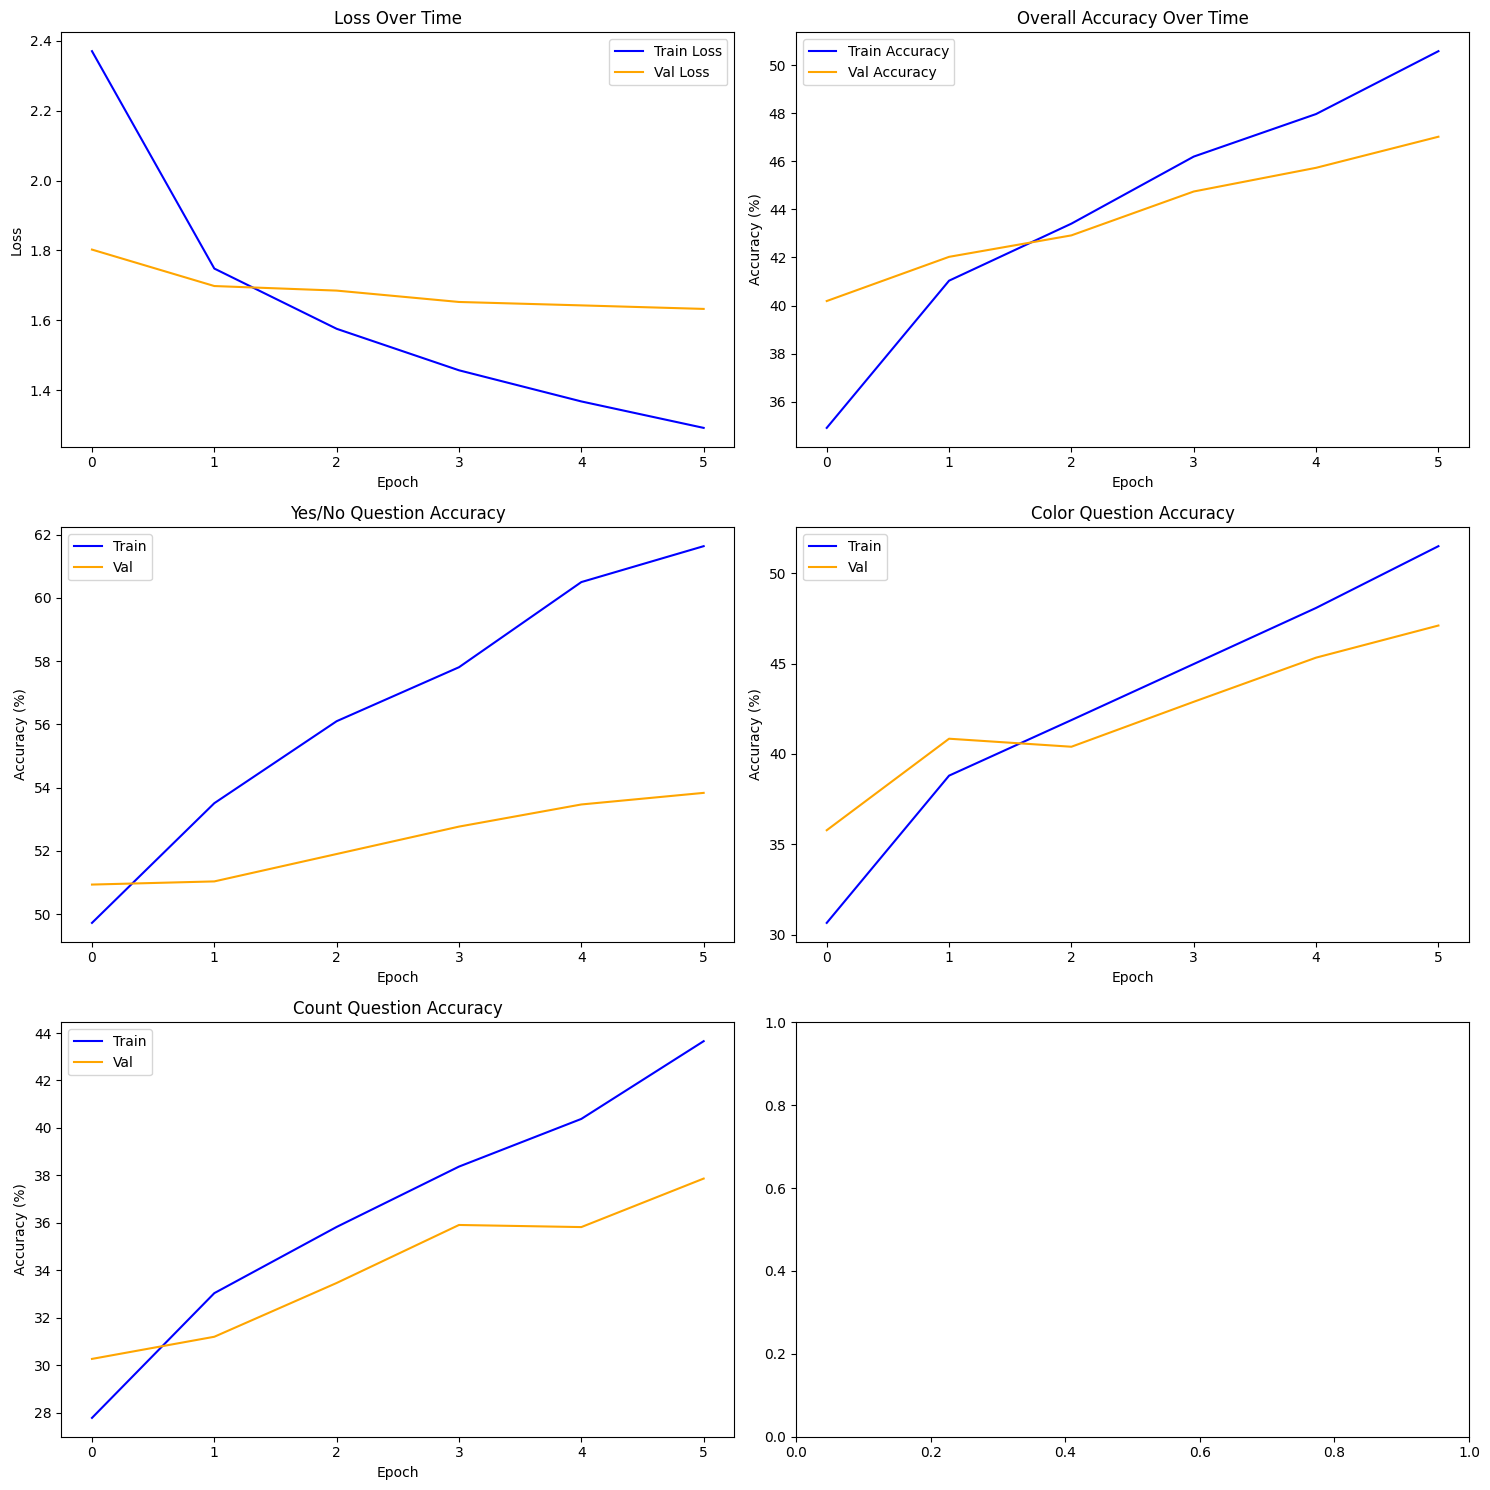

In [ ]:
# Calling training fuction
history = run_clip_vqa_model(config, datasets)


# Plotting
plot_results(history)


## VISUALIZATION


In [ ]:
# Visualizations
def visualize_attention_maps(model, dataloader, num_samples=5):
    model.eval()
    device = next(model.parameters()).device
    samples = []

    # Collecting samples
    for batch in dataloader:
        if len(samples) >= num_samples:
            break
        samples.extend([{
            'image': batch['clip_image'][i],
            'question': {
                'input_ids': batch['question']['input_ids'][i],
                'attention_mask': batch['question']['attention_mask'][i]
            },
            'question_text': batch['question_text'][i],
            'answer_text': batch['answer_text'][i],
            'answer': batch['answer'][i]
        } for i in range(min(num_samples - len(samples), len(batch['clip_image'])))])

    fig = plt.figure(figsize=(20, 5 * num_samples))
    for idx, sample in enumerate(samples):
        with torch.no_grad():

            clip_outputs = model.clip(
                pixel_values=sample['image'].unsqueeze(0).to(device),
                input_ids=sample['question']['input_ids'].unsqueeze(0).to(device),
                attention_mask=sample['question']['attention_mask'].unsqueeze(0).to(device),
                output_attentions=True,
                return_dict=True
            )

            # Prediction of answer
            logits = model(
                sample['image'].unsqueeze(0).to(device),
                {
                    'input_ids': sample['question']['input_ids'].unsqueeze(0).to(device),
                    'attention_mask': sample['question']['attention_mask'].unsqueeze(0).to(device)
                }
            )
            pred = logits['logits'].argmax(dim=1) if isinstance(logits, dict) else logits.argmax(dim=1)
            pred_text = datasets['test'].answer_processor.idx2ans[pred.item()]

            # Attention map
            vision_attentions = clip_outputs.vision_model_output.attentions[-1]
            seq_length = vision_attentions.shape[-1]
            patch_size = int(np.sqrt(seq_length - 1))

            attention_map = vision_attentions.mean(dim=1).squeeze(0)[0, 1:]
            attention_map = attention_map.reshape(patch_size, patch_size)
            attention_map = F.interpolate(
                attention_map.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().numpy()

            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

            # Plotting
            # Original image
            ax = fig.add_subplot(num_samples, 3, idx * 3 + 1)
            img = transforms.ToPILImage()(sample['image'])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title('Original Image')

            # Attention map
            ax = fig.add_subplot(num_samples, 3, idx * 3 + 2)
            im = ax.imshow(attention_map, cmap='hot')
            ax.axis('off')
            ax.set_title('Vision Attention Map')
            plt.colorbar(im, ax=ax)

            # Overlay
            ax = fig.add_subplot(num_samples, 3, idx * 3 + 3)
            ax.imshow(img)
            ax.imshow(attention_map, alpha=0.5, cmap='hot')
            ax.axis('off')
            title = (f"Overlay\nQ: {sample['question_text']}\n"
                     f"Predicted: {pred_text}\nGround Truth: {sample['answer_text']}")
            ax.set_title(title)

    plt.tight_layout()
    plt.show()


In [ ]:
# BLEU AND METEOR SCORES
def calculate_nlp_metrics(model, dataloader, answer_processor):
    nltk.download('wordnet', quiet=True)
    model.eval()
    device = next(model.parameters()).device
    smoother = SmoothingFunction()

    bleu_scores = {'bleu1': [], 'bleu2': [], 'bleu3': []}
    meteor_scores = []
    examples = []

    weights = {
        'bleu1': (1, 0, 0),
        'bleu2': (0.5, 0.5, 0),
        'bleu3': (0.33, 0.33, 0.33)
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating NLP metrics"):
            outputs = model(
                batch['clip_image'].to(device),
                {
                    'input_ids': batch['question']['input_ids'].to(device),
                    'attention_mask': batch['question']['attention_mask'].to(device)
                }
            )

            logits = outputs['logits'] if isinstance(outputs, dict) else outputs
            preds = logits.argmax(dim=1)

            pred_texts = [answer_processor.idx2answer[pred.item()].lower() for pred in preds]
            true_texts = [true.lower() for true in batch['answer_text']]

            for pred, true in zip(pred_texts, true_texts):
                if len(examples) < 5:
                    examples.append((pred, true))

                pred_tokens = pred.split()
                true_tokens = [true.split()]

                if not pred_tokens or not true_tokens[0]:
                    continue

                # BLEU scores
                for name, weight in weights.items():
                    score = sentence_bleu(true_tokens, pred_tokens, weights=weight,
                                          smoothing_function=smoother.method1)
                    bleu_scores[name].append(score)

                # METEOR score
                meteor = meteor_score([true_tokens[0]], pred_tokens)
                if not np.isnan(meteor):
                    meteor_scores.append(meteor)

    return {
        'bleu_scores': {metric: np.mean(scores) for metric, scores in bleu_scores.items()},
        'meteor': np.mean(meteor_scores),
        'examples': examples
    }


In [ ]:
def analyze_model_results(config, datasets):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint_path = os.path.join(config.model_dir, 'best_clip_baseline_vqa.pth')
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Initialize the model
        hidden_size = checkpoint['model_state_dict']['ans_head.2.weight'].shape[0]
        model = CLIPBasedVQA(
            config=config,
            num_answers=len(datasets['test'].answer_processor.ans2idx),
            hidden_size=hidden_size,
            dropout=0.3
        ).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Loaded model (Validation accuracy: {checkpoint['val_accuracy']:.2f}%)")

        # Define dataloaders
        dataloaders = {
            'eval': DataLoader(
                datasets['test'], batch_size=32, shuffle=False, num_workers=0,
                pin_memory=True, collate_fn=collate_fn
            ),
            'viz': DataLoader(
                datasets['test'], batch_size=8, shuffle=True, num_workers=0,
                pin_memory=True, collate_fn=collate_fn
            )
        }

        results = {}

        # Attention maps
        print("\nGenerating attention maps...")
        visualize_attention_maps(model, dataloaders['viz'], num_samples=5)

        # NLP metrics
        print("\nCalculating NLP metrics...")
        nlp_metrics = calculate_nlp_metrics(model, dataloaders['eval'], datasets['test'].answer_processor)
        results['nlp_metrics'] = nlp_metrics

        # Analysis of question types
        print("\nAnalyzing question types...")
        type_metrics = {'yes/no': [], 'color': [], 'count': []}

        with torch.no_grad():
            for batch in tqdm(dataloaders['eval'], desc="Evaluating question types"):
                outputs = model(
                    batch['clip_image'].to(device),
                    {
                        'input_ids': batch['question']['input_ids'].to(device),
                        'attention_mask': batch['question']['attention_mask'].to(device)
                    }
                )

                logits = outputs['logits'] if isinstance(outputs, dict) else outputs
                preds = logits.argmax(dim=1)

                for i, (pred, true) in enumerate(zip(preds, batch['answer'].to(device))):
                    q_type = batch['question_type'][i]
                    if q_type in type_metrics:
                        type_metrics[q_type].append((pred == true).item())

        # Calculation of accuracies
        results['question_type_accuracy'] = {
            q_type: np.mean(scores) * 100 for q_type, scores in type_metrics.items()
        }

        # Results
        print("\nResults Summary:")
        print(f"BLEU-1: {nlp_metrics['bleu_scores']['bleu1']:.4f}")
        print(f"METEOR: {nlp_metrics['meteor']:.4f}")
        print("\nAccuracy by Question Type:")
        for q_type, acc in results['question_type_accuracy'].items():
            print(f"{q_type}: {acc:.2f}%")

        return results

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None


def run_analysis():
    config = VQAConfig()
    results = analyze_model_results(config, datasets)
    if not results:
        print("Analysis failed")

C:\Users\csury\AppData\Local\Temp\ipykernel_12596\2546166981.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Loaded model (Validation accuracy: 47.03%)

Generating attention maps...


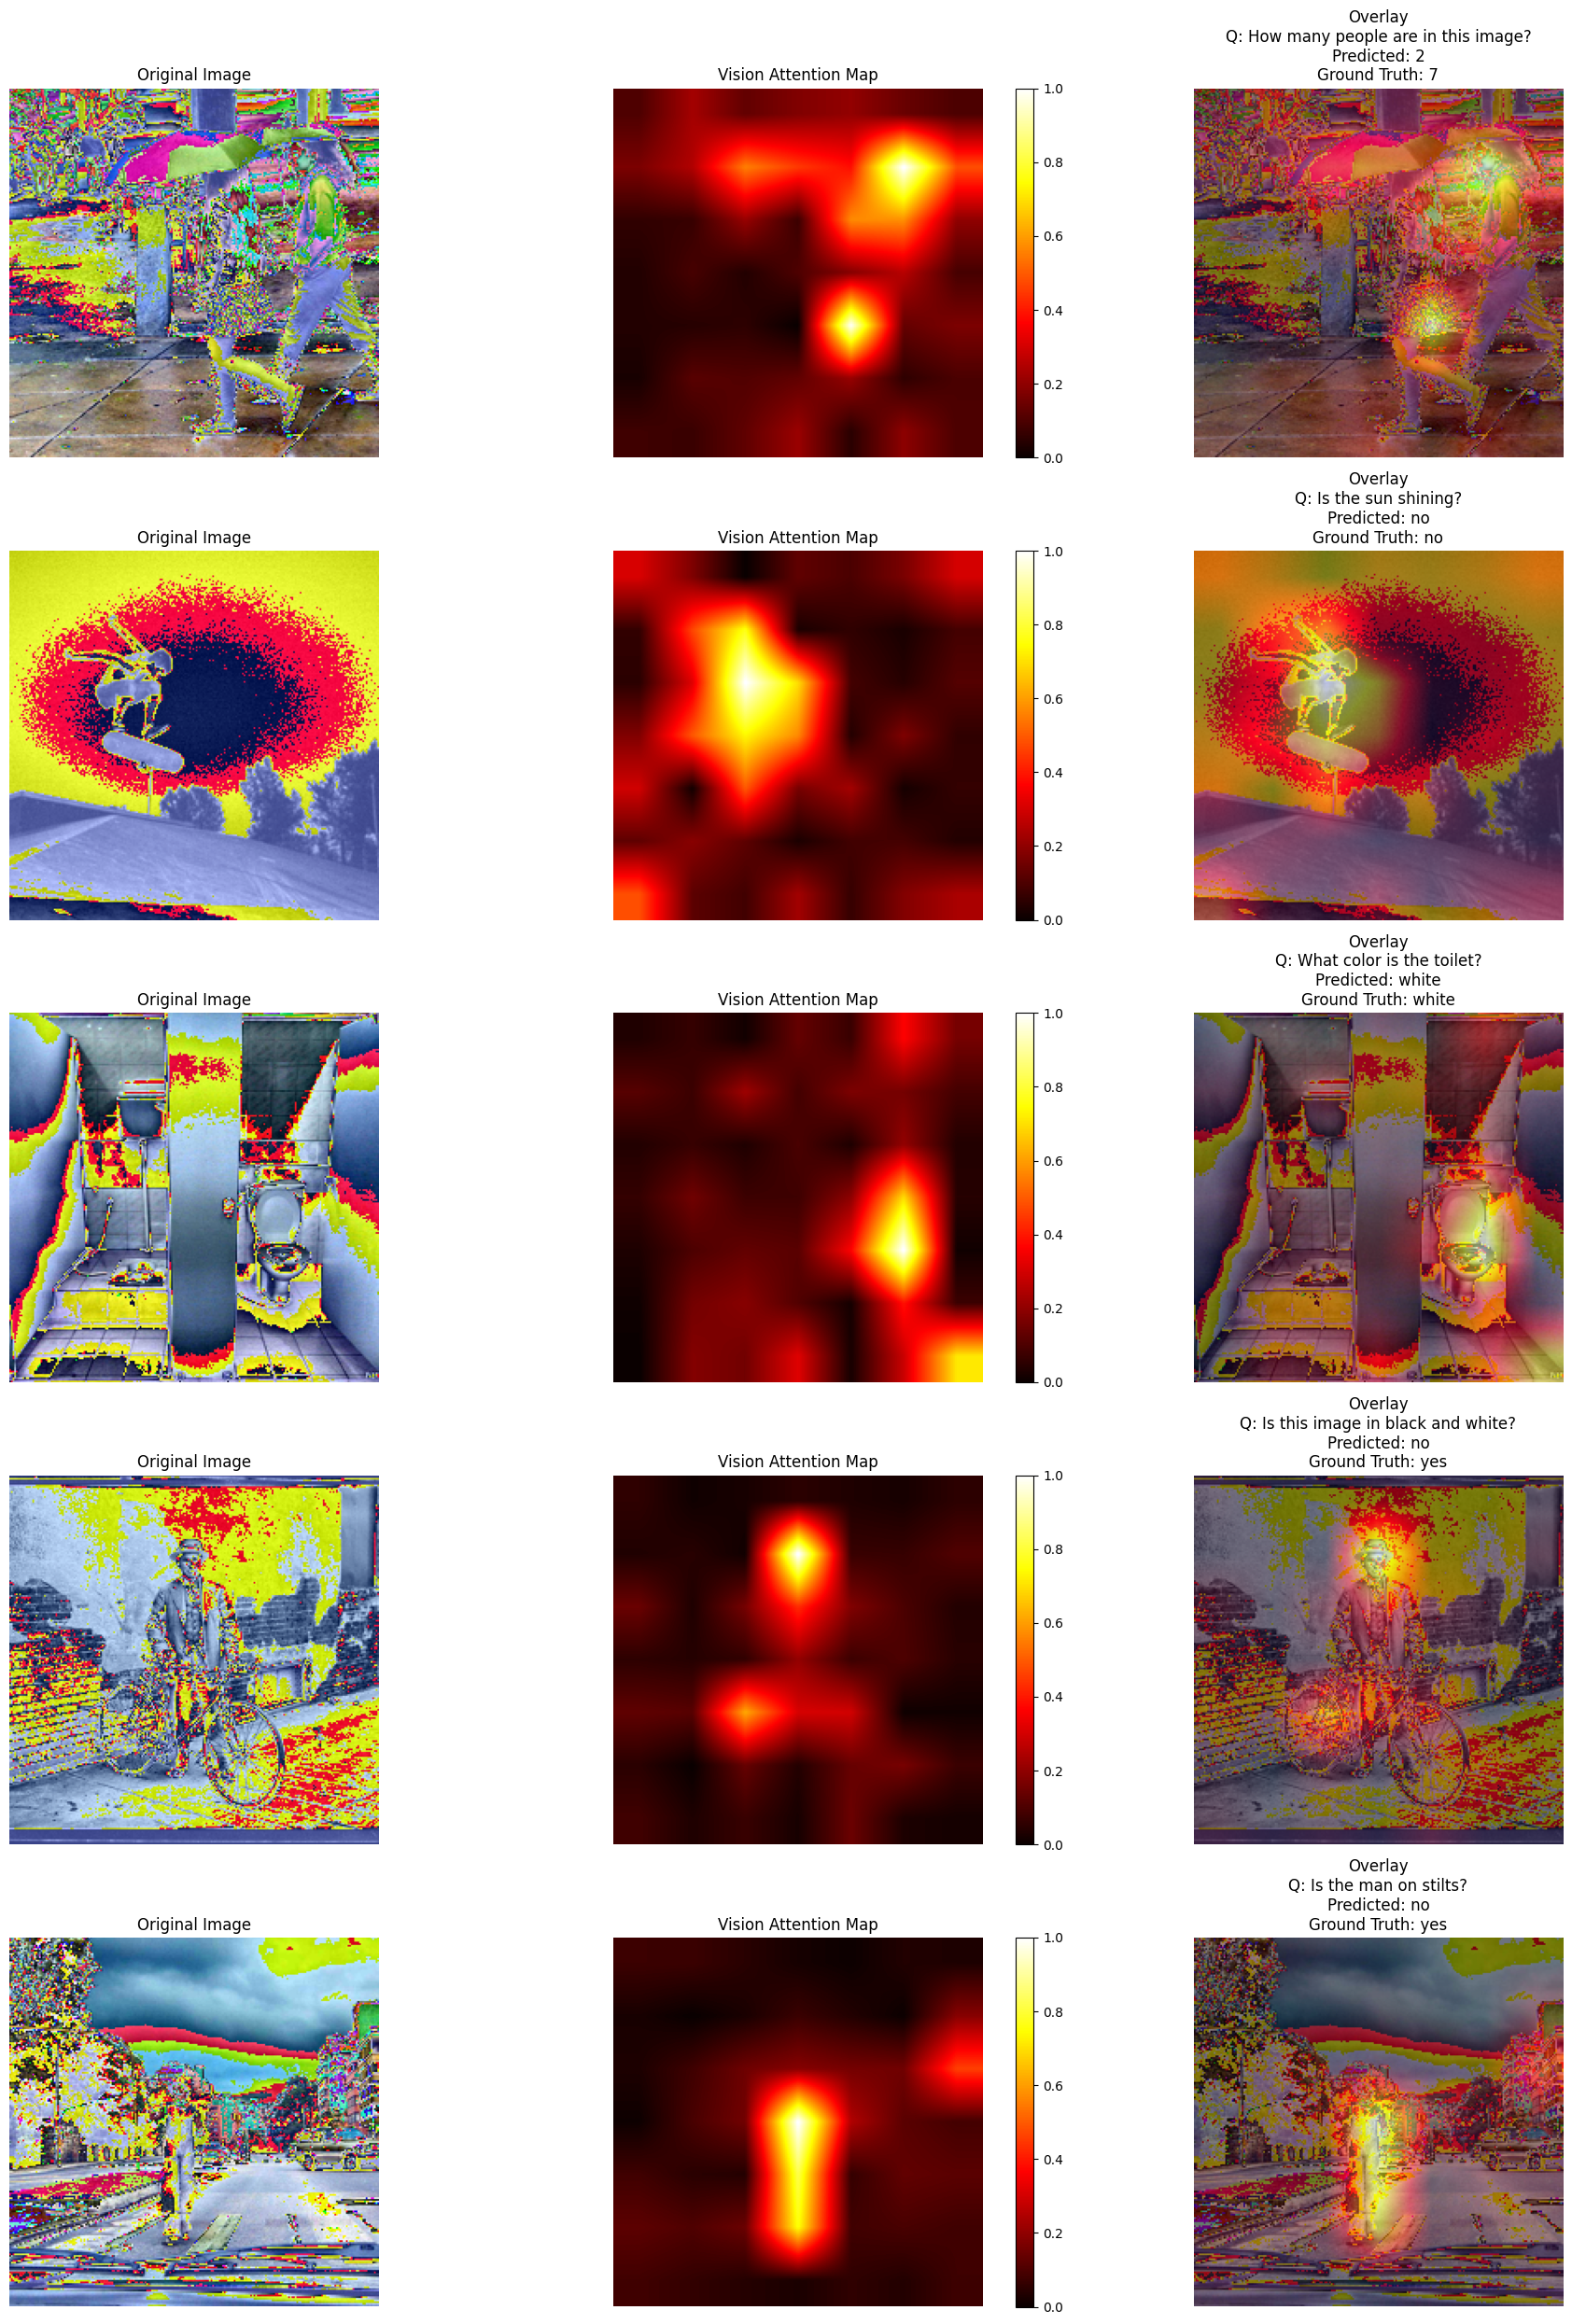


Calculating NLP metrics...


Calculating NLP metrics: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]



Analyzing question types...


100%|██████████| 235/235 [02:36<00:00,  1.50it/s]


Results Summary:
BLEU-1: 0.4672
METEOR: 0.2382

Accuracy by Question Type:
yes/no: 51.93%
color: 47.78%
count: 37.82%


In [13]:
run_analysis()

## TESTING


C:\Users\csury\AppData\Local\Temp\ipykernel_16100\1727490848.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model loaded successfully from C:\Users\csury\Documents\DL\PROJECT\models\best_clip_baseline_vqa.pth
Validation accuracy: 47.03%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34503675..1.5658386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5729485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5729485].



Sample 1:
Question: How many kites are in the air?
Question: Not available
Model's Answer: 1
Ground Truth: 15
Confidence: 30.50%

Sample 2:
Question: What color are the walls?
Question: Not available
Model's Answer: white
Ground Truth: white
Confidence: 58.21%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20970345..1.1890068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5729485].



Sample 3:
Question: How many computer mice are in this picture?
Question: Not available
Model's Answer: 2
Ground Truth: 1
Confidence: 45.33%

Sample 4:
Question: How many power lines are there?
Question: Not available
Model's Answer: 3
Ground Truth: 3
Confidence: 33.49%

Sample 5:
Question: Is this donut tasty?
Question: Not available
Model's Answer: no
Ground Truth: yes
Confidence: 70.98%


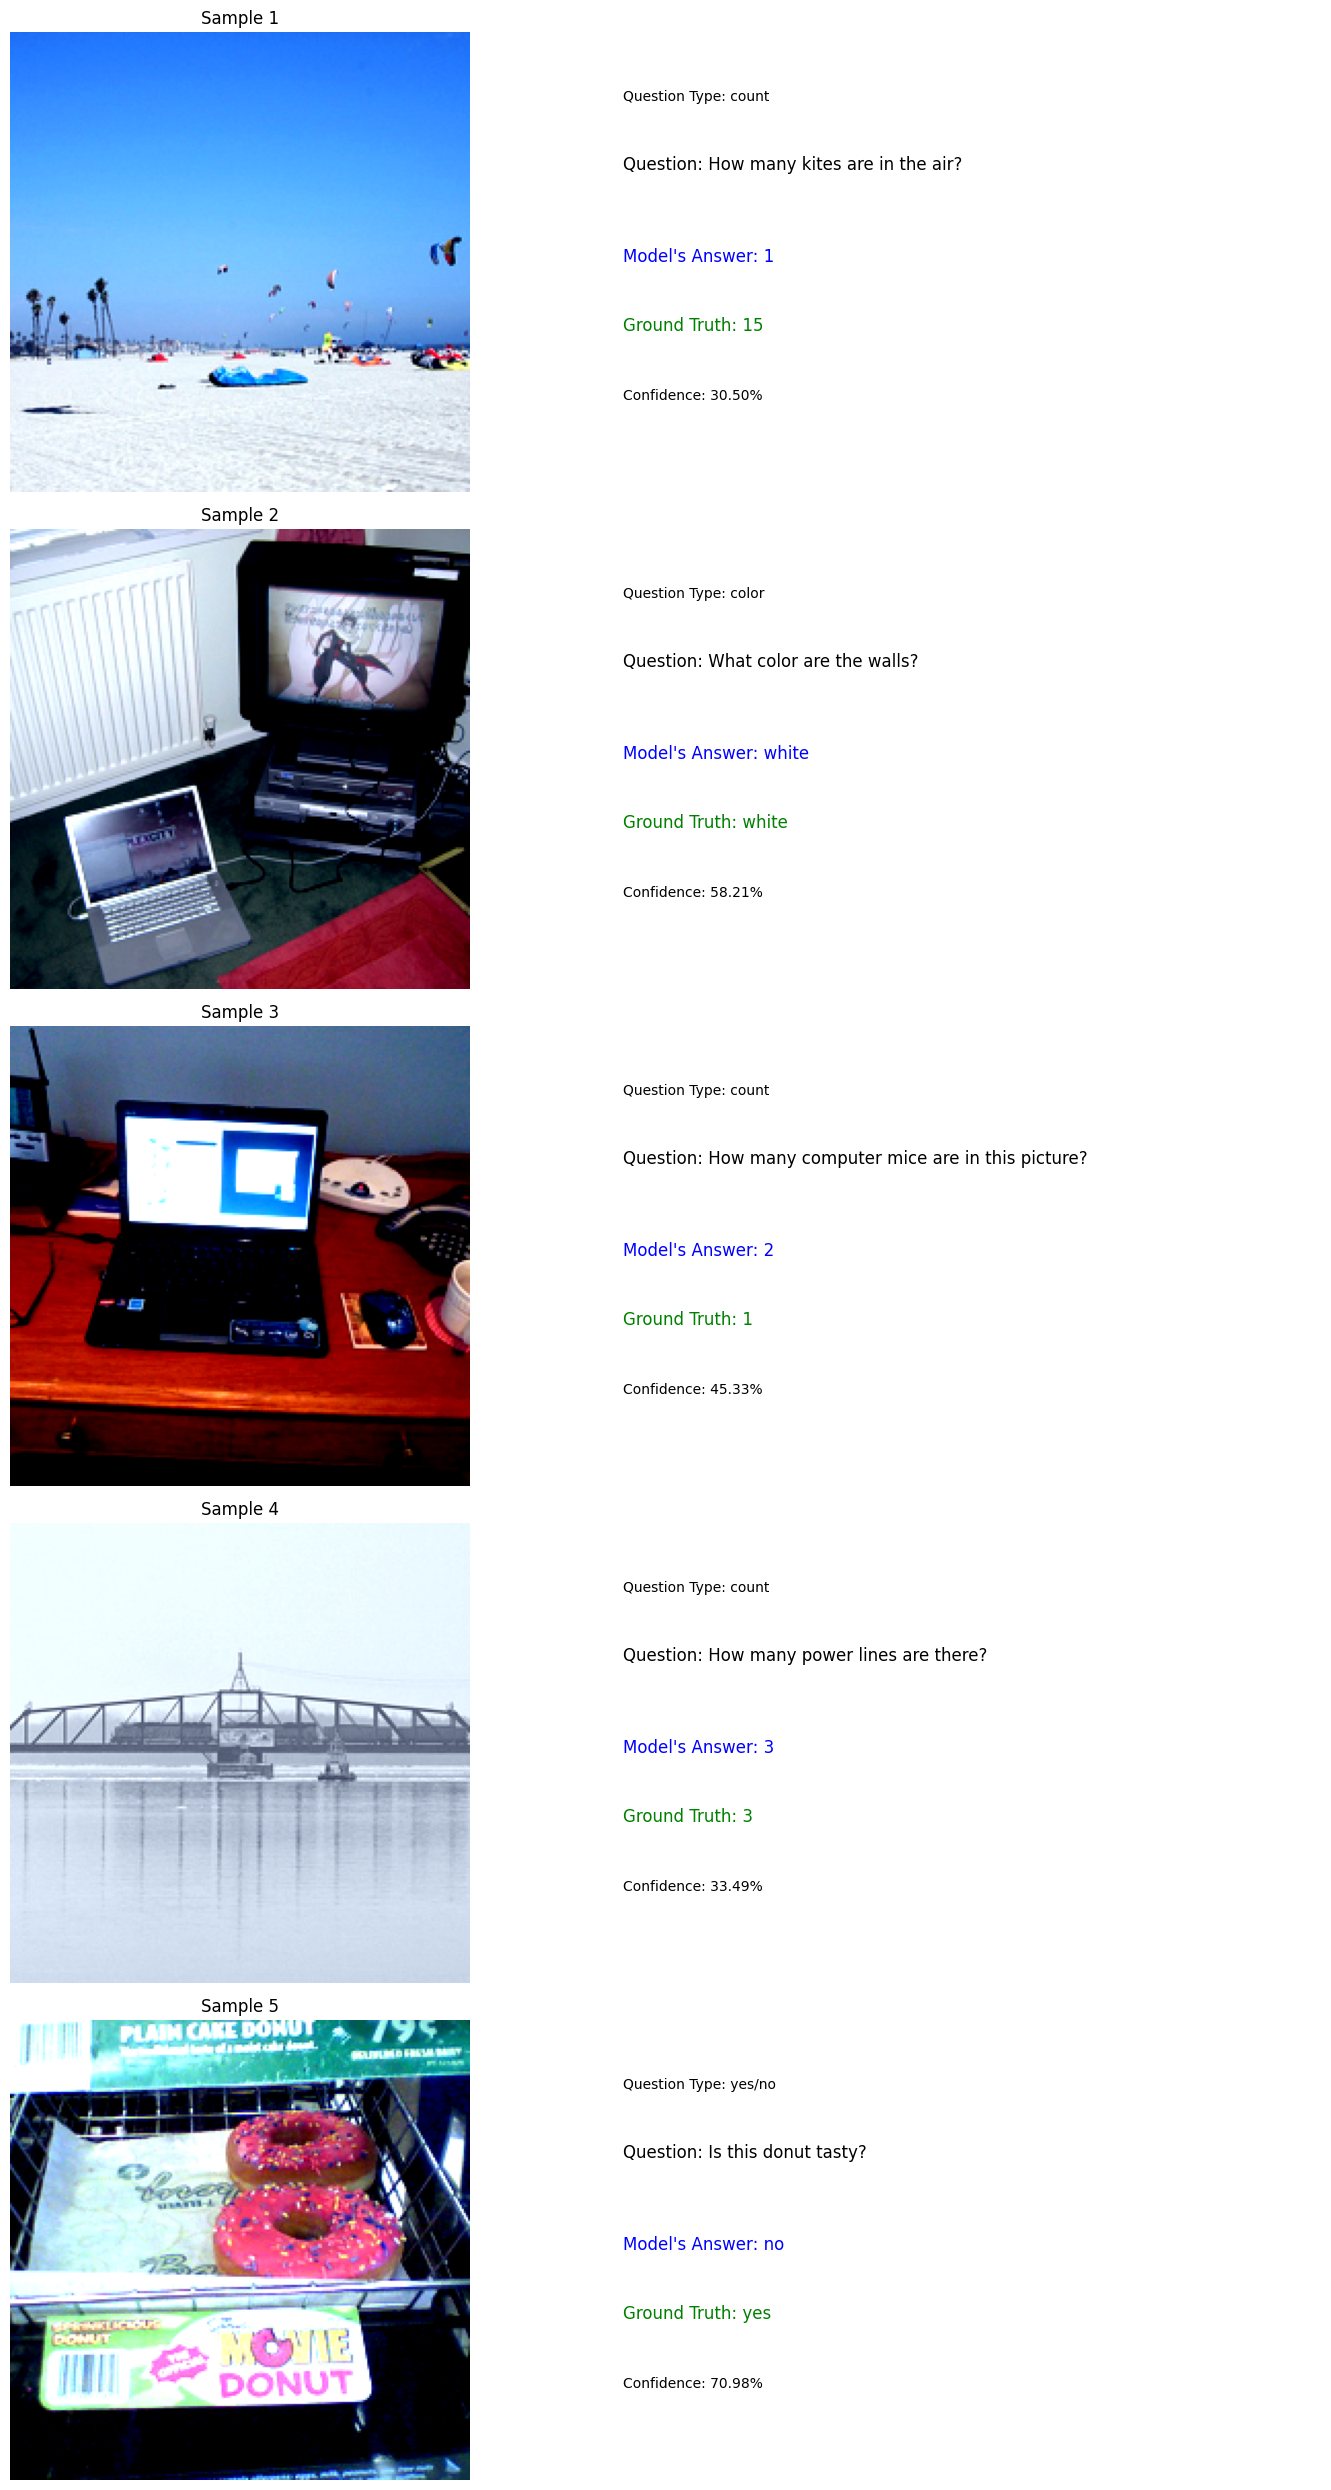

In [ ]:
def test_vqa_model_random(model, test_dataset, num_samples=5):
    model.eval()
    device = next(model.parameters()).device

    # Random indices
    total_samples = len(test_dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))


    fig = plt.figure(figsize=(15, 5 * num_samples))

    for idx, sample_idx in enumerate(random_indices):
        sample = test_dataset[sample_idx]

        # Preparing input
        clip_image = sample['clip_image'].unsqueeze(0).to(device)
        question_input = {
            'input_ids': sample['question']['input_ids'].unsqueeze(0).to(device),
            'attention_mask': sample['question']['attention_mask'].unsqueeze(0).to(device)
        }

        # Getting ground truth answer
        true_answer = test_dataset.answer_processor.idx2answer[sample['answer']]

        # Getting model prediction
        with torch.no_grad():
            output = model(clip_image, question_input)
            logits = output['logits'] if isinstance(output, dict) else output
            pred_idx = logits.argmax(dim=1).item()
            pred_answer = test_dataset.answer_processor.idx2answer.get(pred_idx, "Unknown")
            confidence = torch.softmax(logits, dim=1).max().item()

        # Results
        plt.subplot(num_samples, 2, 2 * idx + 1)

        if isinstance(sample['clip_image'], torch.Tensor):
            img = sample['clip_image'].cpu() * 0.5 + 0.5 
            img = img.permute(1, 2, 0).numpy()
            plt.imshow(img)

        plt.axis('off')
        plt.title(f'Sample {idx + 1}')

        # Q&A details
        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.axis('off')
        plt.text(0.1, 0.85, f"Question Type: {sample['question_type']}", wrap=True, fontsize=10)
        plt.text(0.1, 0.7, f"Question: {sample['question_text']}", wrap=True, fontsize=12)
        plt.text(0.1, 0.5, f"Model's Answer: {pred_answer}", wrap=True, fontsize=12, color='blue')
        plt.text(0.1, 0.35, f"Ground Truth: {true_answer}", wrap=True, fontsize=12, color='green')
        plt.text(0.1, 0.2, f"Confidence: {confidence:.2%}", wrap=True, fontsize=10)


        print(f"\nSample {idx + 1}:")
        print(f"Question: {sample['question_text']}")
        print(f"Model's Answer: {pred_answer}")
        print(f"Ground Truth: {true_answer}")
        print(f"Confidence: {confidence:.2%}")

    plt.tight_layout()
    plt.show()




def evaluate_model_on_random_samples(config, test_dataset, model_type='clip_baseline', num_samples=5):
    checkpoint_path = os.path.join(config.model_dir, f'best_{model_type}_vqa.pth')

    if not os.path.exists(checkpoint_path):
        print(f"Model checkpoint not found at {checkpoint_path}")
        return

    try:
        # Initialization
        num_answers = len(test_dataset.answer_processor.answer2idx)
        model = CLIPBasedVQA(
            config=config,
            num_answers=num_answers,
            hidden_size=768,
            dropout=0.1
        )

        # Loading checkpoint
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(model.device)
        model.eval()

        print(f"Model loaded successfully from {checkpoint_path}")
        print(f"Validation accuracy: {checkpoint['val_metrics']['accuracy']:.2f}%")

        test_vqa_model_random(model, test_dataset, num_samples)

    except Exception as e:
        print(f"Error during model evaluation: {e}")
        raise





# Usage
evaluate_model_on_random_samples(config, datasets['test'], model_type='clip_baseline', num_samples=5)